# Recommendation System
### Using Matrix Factorization and Neural Collaborative Filtering

During this experiment we will be testing Matrix Factorization and Neural Collaborative Filtering for recommendation engines, using Movie Lens 20 Millions Dataset

References:
F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages. DOI=<http://dx.doi.org/10.1145/2827872>

Exploratory Data Analysis, Model Definition, Training and Fine-Tunning described step by step on this Notebook

In [0]:
from IPython.display import clear_output
!pip install --upgrade tensorflow-gpu
clear_output()

In [0]:
#Downloads and extract Dataset to local, wait for download, i dont want to put a progress bar here sorry
#You can run this on google colab for get faster downloads speeds
import os
import zipfile
import requests

if(not os.path.exists("./Datasets/MoviLens20M.zip")):

  resp = requests.get("http://files.grouplens.org/datasets/movielens/ml-20m.zip")

  os.mkdir("./Datasets")

  with open("./Datasets/MoviLens20M.zip", "wb") as f:
    f.write(resp.content)

  with zipfile.ZipFile("./Datasets/MoviLens20M.zip", "r") as zip_ref:
    zip_ref.extractall("./Datasets")


In [0]:
#Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from google.colab import drive
drive.mount('/content/drive')
clear_output()

## Exploratory Data Analysis

Simple exploration without too much fancy graphs

In [0]:
#Loads Dataset, we only need ratings.csv and movies.csv files, we can drop timestamp and genres for now
ratings_df = pd.read_csv("./Datasets/ml-20m/ratings.csv").drop(["timestamp"], axis=1)
movies_df = pd.read_csv("./Datasets/ml-20m/movies.csv").drop(["genres"], axis=1)

ml_df = ratings_df.merge(movies_df, on="movieId")

ml_df = ml_df.reindex(columns=["userId", "movieId", "title", "rating"])
ml_df.head()

,userId,movieId,title,rating
0,1,2,Jumanji (1995),3.5
1,5,2,Jumanji (1995),3.0
2,13,2,Jumanji (1995),3.0
3,29,2,Jumanji (1995),3.0
4,34,2,Jumanji (1995),3.0


In [0]:
#Check info about the Dataset
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
userId     int64
movieId    int64
title      object
rating     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 762.9+ MB


In [0]:
#Check for NaNs
ml_df.isna().sum()

userId     0
movieId    0
title      0
rating     0
dtype: int64

In [0]:
#List unique values of each column
n_users = ml_df["userId"].max()
n_movies = ml_df["movieId"].nunique()

print("Unique Users: " + str(n_users))
print("Unique Movies: " + str(n_movies))

Unique Users: 138493
Unique Movies: 26744


In [0]:
#Top movies with more rating count (dont confuse with more views or more rating score, but are correlated)
count = ml_df["title"].value_counts()
count[:15]

Pulp Fiction (1994)                          67310
Forrest Gump (1994)                          66172
Shawshank Redemption, The (1994)             63366
Silence of the Lambs, The (1991)             63299
Jurassic Park (1993)                         59715
Star Wars: Episode IV - A New Hope (1977)    54502
Braveheart (1995)                            53769
Terminator 2: Judgment Day (1991)            52244
Matrix, The (1999)                           51334
Schindler's List (1993)                      50054
Toy Story (1995)                             49695
Fugitive, The (1993)                         49581
Apollo 13 (1995)                             47777
Independence Day (a.k.a. ID4) (1996)         47048
Usual Suspects, The (1995)                   47006
Name: title, dtype: int64

## Preprocessing

In [0]:
#Normalize ratings
ml_df["rating_norm"] = ml_df["rating"] / 5.0

#Set Ids as categorical data
ml_df["userId"] = ml_df["userId"].astype("category").cat.codes.values
ml_df["movieId"] = ml_df["movieId"].astype("category").cat.codes.values
ml_df.head()

,userId,movieId,title,rating,rating_norm
0,0,1,Jumanji (1995),3.5,0.7
1,4,1,Jumanji (1995),3.0,0.6
2,12,1,Jumanji (1995),3.0,0.6
3,28,1,Jumanji (1995),3.0,0.6
4,33,1,Jumanji (1995),3.0,0.6


In [0]:
#Redimension Target data.
users = ml_df["userId"].values
movies = ml_df["movieId"].values
ratings = ml_df["rating_norm"].values.reshape([-1, 1])

In [0]:
#Create Datasets for train, evaluation and testing, and a full version of the dataset
#Note: Value of shuffle buffer arguments is crucial for get well distributed dataset slices
ml_ds = tf.data.Dataset.from_tensor_slices(({"userId":users, "movieId":movies}, ratings)).shuffle(200000)
full_ds = ml_ds
eval_ds = ml_ds.take(10000).batch(10000)
ml_ds = ml_ds.skip(10000)
test_ds = ml_ds.take(10000).batch(10000)
train_ds = ml_ds.skip(10000)

<Figure size 432x288 with 0 Axes>

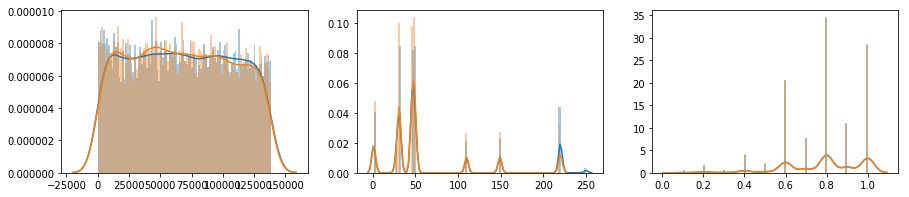

In [0]:
#Check distributions of dataset slices, if both dist are close, we can inffer the distribution between the three datasets comes from the same distribution
plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
sns.distplot([sample["userId"] for sample, rating in test_ds], bins=100)
sns.distplot([sample["userId"] for sample, rating in eval_ds], bins=100)

plt.subplot(1, 3, 2)
sns.distplot([sample["movieId"] for sample, rating in test_ds], bins=100)
sns.distplot([sample["movieId"] for sample, rating in eval_ds], bins=100)

plt.subplot(1, 3, 3)
sns.distplot([rating for sample, rating in test_ds], bins=100)
sns.distplot([rating for sample, rating in eval_ds], bins=100)

plt.show()